In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import math


fx = 1030
fy = 540
cx = 1030
cy = 540
camera_matrix = np.matrix([  [fx, 0, cx],
                            [0, fy, cy],
                            [0,  0, 1]],  dtype=np.float32)
gt_points = np.array([[-155.6, 0.8, 21.8911],
                    [98.3, 7.2, 21.8911],
                    [76.4, -15, 21.8911],
                    [-155.6, -20.4, 21.8911]],dtype=np.float32) 
ned_origin_in_ue4_ref = np.array([[-134.4, -10.75, 22.8],
                                [-134.4, -10.75, 22.8],
                                [-134.4, -10.75, 22.8],
                                [-134.4, -10.75, 22.8]],dtype=np.float32)

gt_points = gt_points - ned_origin_in_ue4_ref
gt_points[:,2] = -gt_points[:,2]
dist_coeffs = np.zeros((5, 1))

def RotateByZ(Cx, Cy, Z):
    rz = Z*math.pi/180.0
    outX = math.cos(rz)*Cx - math.sin(rz)*Cy
    outY = math.sin(rz)*Cx + math.cos(rz)*Cy
    return outX, outY
def RotateByY(Cx, Cz, Y):
    ry = Y*math.pi/180.0
    outZ = math.cos(ry)*Cz - math.sin(ry)*Cx
    outX = math.sin(ry)*Cz + math.cos(ry)*Cx
    return outX, outZ
def RotateByX(Cy, Cz, X):
    rx = X*math.pi/180.0
    outY = math.cos(rx)*Cy - math.sin(rx)*Cz
    outZ = math.sin(rx)*Cy + math.cos(rx)*Cz
    return outY, outZ
def rotationMatrixToEulerAngles(rvecs):
    R = np.zeros((3, 3), dtype=np.float64)
    cv2.Rodrigues(rvecs, R)
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular:
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    X = x*180.0/math.pi
    Y = y*180.0/math.pi
    Z = z*180.0/math.pi
    return X,Y,Z

def Euler2Quaternion(pose):
    # yaw = heading
    p, y, r = pose[:3]
    sinp = math.sin(p/2)
    siny = math.sin(y/2)
    sinr = math.sin(r/2)

    cosp = math.cos(p/2)
    cosy = math.cos(y/2)
    cosr = math.cos(r/2)
    w = cosr*cosp*cosy + sinr*sinp*siny
    x = sinr*cosp*cosy - cosr*sinp*siny
    y = cosr*sinp*cosy + sinr*cosp*siny
    z = cosr*cosp*siny - sinr*sinp*cosy
    return [w,x,y,z]

def Quaternion2Euler(w,x,y,z):
    # yaw = heading
#     w,x,y,z = q
    r = math.atan2(2 * (w * x + y * z), 1 - 2 * (x * x + y * y))
    p = math.asin(2 * (w * y - z * x))
    y = math.atan2(2 * (w * z + x * y), 1 - 2 * (y * y + z * z))
    return [p,y,r]

def calc_pnp(image_points):
#     print("image_points:")
#     print(image_points)
#     print("gt_points:")
#     print(gt_points)        
    (success, rotation_vector, translation_vector,inliners) = cv2.solvePnPRansac(gt_points, image_points, camera_matrix, dist_coeffs)
# ,flags=cv2.SOLVEPNP_P3P
    print("calc pnp:")
#     print(success)
#     print(rotation_vector)
#     print(translation_vector)

    R = rotationMatrixToEulerAngles(rotation_vector)
    print("Estimate Euler:",R)
    x,y,z = translation_vector
    (x, y) = RotateByZ(x, y, -1.0*R[2])
    (x, z) = RotateByY(x, z, -1.0*R[1])
    (y, z) = RotateByX(y, z, -1.0*R[0])

    #     print("gt_points:")
    print("ned_position:")
    print("pos_x:",-1*x)
    print("pos_y:",-1*y)
    print("pos_z:",-1*z)
    quaternion = Euler2Quaternion(R)
    print("quaternion:",quaternion)
    return [-1*x,-1*y,-1*z]


calc pnp:
True
[[-1.30977829]
 [ 1.25409072]
 [ 1.25309698]]
[[  -6.59344749]
 [ 301.51106186]
 [1107.78689503]]
Estimate Euler: (155.08506334254153, 85.10422592539766, -110.43989972072816)
[[-21.200012   11.55        0.9088993]
 [232.7        17.95        0.9088993]
 [210.79999    -4.25        0.9088993]
 [-21.200012   -9.65        0.9088993]]
ned_position:
pos_x: [1127.66060564]
pos_y: [-23.30678696]
pos_z: [-214.43542372]
quaternion: [-0.8256882325896401, 0.12555276612353725, 0.5497866976435517, 0.014492500678725567]

In [2]:
gt_file = "/home/lilong/Biyesheji/deeplabv3-plus-pytorch/datasets/normal/airsim_rec.txt"
pred_file = "/home/lilong/Biyesheji/deeplabv3-plus-pytorch/datasets/normal/point_estimate_result.txt"

df = pd.read_table(gt_file)
df.sort_values("ImageFile")
pred_df = pd.read_table(pred_file)
pred_df.sort_values("FileName")

total = pd.concat([df,pred_df],axis=1)
total

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,ImageFile,FileName,P0_X,P0_Y,P1_X,P1_Y,P2_X,P2_Y,P3_X,P3_Y
0,SimpleFlight,1648988397609,1155.270,-71.94500,-99.3599,-0.025432,0.028131,0.001381,-0.999280,img_SimpleFlight__0_1648988397790020000.png,img_SimpleFlight__0_1648988397790020000.png,None,None,None,None,None,None,None,None
1,SimpleFlight,1648988398380,1149.870,-71.68300,-99.3955,-0.026252,0.027809,0.001311,-0.999268,img_SimpleFlight__0_1648988398561051000.png,img_SimpleFlight__0_1648988398561051000.png,None,None,None,None,None,None,None,None
2,SimpleFlight,1648988399175,1143.470,-71.36130,-99.4340,-0.027253,0.027770,0.001361,-0.999242,img_SimpleFlight__0_1648988399354153000.png,img_SimpleFlight__0_1648988399354153000.png,None,None,None,None,None,None,None,None
3,SimpleFlight,1648988399958,1138.300,-71.09280,-99.4641,-0.028071,0.027574,0.001202,-0.999225,img_SimpleFlight__0_1648988400138949000.png,img_SimpleFlight__0_1648988400138949000.png,None,None,None,None,None,None,None,None
4,SimpleFlight,1648988400780,1132.400,-70.77640,-99.4967,-0.028954,0.027304,0.000994,-0.999207,img_SimpleFlight__0_1648988400959452000.png,img_SimpleFlight__0_1648988400959452000.png,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,SimpleFlight,1648988543856,149.746,7.47912,-39.2453,-0.110753,-0.103680,-0.000187,-0.988425,img_SimpleFlight__0_1648988544047272000.png,img_SimpleFlight__0_1648988544047272000.png,None,None,None,None,None,None,None,None
217,SimpleFlight,1648988544676,142.549,9.02207,-37.5601,-0.111927,-0.103085,-0.000245,-0.988355,img_SimpleFlight__0_1648988544864045000.png,img_SimpleFlight__0_1648988544864045000.png,None,None,None,None,None,None,None,None
218,SimpleFlight,1648988545477,136.322,10.37070,-36.1101,-0.112928,-0.103273,-0.000303,-0.988221,img_SimpleFlight__0_1648988545666991000.png,img_SimpleFlight__0_1648988545666991000.png,None,None,None,None,None,None,None,None
219,SimpleFlight,1648988546287,131.211,11.48750,-34.9188,-0.113720,-0.103714,-0.000416,-0.988084,img_SimpleFlight__0_1648988546476166000.png,img_SimpleFlight__0_1648988546476166000.png,None,None,None,None,None,None,None,None


In [3]:
pred_x = []
pred_y = []
pred_z = []
gt_pitch = []
gt_yaw = []
gt_roll = []
pred_pitch = []
pred_yaw = []
pred_roll = []

for row in total.iterrows():
    p,y,r = Quaternion2Euler(row[1]["Q_W"],row[1]["Q_X"],row[1]['Q_Y'],row[1]["Q_Z"])
    gt_pitch.append(p)
    gt_yaw.append(y)
    gt_roll.append(r)
    
    print("gt position:")
    print(row[1]["POS_X"],row[1]["POS_Y"],row[1]['POS_Z'])
#     print(row[1])
#     print(row[1]["P0_X"])
    if row[1]["P0_X"] == "None" or row[1]["P0_X"] is None:
        pred_x.append(np.nan)
        pred_y.append(np.nan)
        pred_z.append(np.nan)
        pred_pitch.append(np.nan)
        pred_yaw.append(np.nan)
        pred_roll.append(np.nan)
        continue
    p0 = [row[1]["P0_X"],row[1]["P0_Y"]]
    p1 = [row[1]["P1_X"],row[1]["P1_Y"]]
    p2 = [row[1]["P2_X"],row[1]["P2_Y"]]
    p3 = [row[1]["P3_X"],row[1]["P3_Y"]]
    points = np.array([p0,p1,p2,p3],dtype=np.float32)
    temp_x, temp_y, temp_z = calc_pnp(points)
    pred_x.append(temp_x)
    pred_y.append(temp_y)
    pred_z.append(temp_z)
    print("gt rotation:")
    print([p,y,r])

    

gt position:
1155.27 -71.945 -99.3599
gt position:
1149.87 -71.683 -99.3955
gt position:
1143.47 -71.3613 -99.434
gt position:
1138.3 -71.0928 -99.4641
gt position:
1132.4 -70.7764 -99.4967
gt position:
1125.76 -70.4089 -99.5291
gt position:
1119.85 -70.0726 -99.5538
gt position:
1115.41 -69.8154 -99.5706
gt position:
1111.18 -69.5669 -99.5851
calc pnp:
Estimate Euler: (155.08506334254153, 85.10422592539766, -110.43989972072816)
ned_position:
pos_x: [1127.66060564]
pos_y: [-23.30678696]
pos_z: [-214.43542372]
quaternion: [-0.8256882325896401, 0.12555276612353725, 0.5497866976435517, 0.014492500678725567]
gt rotation:
[0.05188754424662342, 3.078770752020627, -0.0005444849595980569]
gt position:
1105.38 -69.2218 -99.6013
gt position:
1099.81 -68.8872 -99.614
gt position:
1095.89 -68.6507 -99.6223
gt position:
1090.49 -68.3228 -99.6342
gt position:
1085.77 -68.0352 -99.6465
calc pnp:
Estimate Euler: (131.54332877260453, 82.6333898151257, -119.48245010819778)
ned_position:
pos_x: [1146.696

calc pnp:
Estimate Euler: (154.7197467799877, 80.72491578631903, -106.83096155624924)
ned_position:
pos_x: [493.79248466]
pos_y: [-0.94066036]
pos_z: [-133.78991487]
quaternion: [-0.3346444783284486, 0.4283431565319538, 0.8193461329687043, 0.1822282298815227]
gt rotation:
[0.039782495198742995, 3.075088550613097, 0.0017824001119791722]
gt position:
531.789 -33.8808 -99.8338
calc pnp:
Estimate Euler: (170.89255350088834, 80.32657673147408, -100.12789877739881)
ned_position:
pos_x: [484.85735037]
pos_y: [-17.42485956]
pos_z: [-124.07103703]
quaternion: [0.5466457635637485, 0.4850918114192905, 0.34373600940548177, -0.589669313691795]
gt rotation:
[0.039576079656278504, 3.075107251280855, 0.002606223885328344]
gt position:
527.832 -33.6312 -99.8325
calc pnp:
Estimate Euler: (156.99286445915845, 80.79372396646666, -107.94485027127384)
ned_position:
pos_x: [481.77505587]
pos_y: [-8.98026333]
pos_z: [-132.57568779]
quaternion: [-0.7518911277681276, 0.4990761930287729, -0.19675117414112064, 0.

In [4]:
total

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,ImageFile,FileName,P0_X,P0_Y,P1_X,P1_Y,P2_X,P2_Y,P3_X,P3_Y
0,SimpleFlight,1648988397609,1155.270,-71.94500,-99.3599,-0.025432,0.028131,0.001381,-0.999280,img_SimpleFlight__0_1648988397790020000.png,img_SimpleFlight__0_1648988397790020000.png,None,None,None,None,None,None,None,None
1,SimpleFlight,1648988398380,1149.870,-71.68300,-99.3955,-0.026252,0.027809,0.001311,-0.999268,img_SimpleFlight__0_1648988398561051000.png,img_SimpleFlight__0_1648988398561051000.png,None,None,None,None,None,None,None,None
2,SimpleFlight,1648988399175,1143.470,-71.36130,-99.4340,-0.027253,0.027770,0.001361,-0.999242,img_SimpleFlight__0_1648988399354153000.png,img_SimpleFlight__0_1648988399354153000.png,None,None,None,None,None,None,None,None
3,SimpleFlight,1648988399958,1138.300,-71.09280,-99.4641,-0.028071,0.027574,0.001202,-0.999225,img_SimpleFlight__0_1648988400138949000.png,img_SimpleFlight__0_1648988400138949000.png,None,None,None,None,None,None,None,None
4,SimpleFlight,1648988400780,1132.400,-70.77640,-99.4967,-0.028954,0.027304,0.000994,-0.999207,img_SimpleFlight__0_1648988400959452000.png,img_SimpleFlight__0_1648988400959452000.png,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,SimpleFlight,1648988543856,149.746,7.47912,-39.2453,-0.110753,-0.103680,-0.000187,-0.988425,img_SimpleFlight__0_1648988544047272000.png,img_SimpleFlight__0_1648988544047272000.png,None,None,None,None,None,None,None,None
217,SimpleFlight,1648988544676,142.549,9.02207,-37.5601,-0.111927,-0.103085,-0.000245,-0.988355,img_SimpleFlight__0_1648988544864045000.png,img_SimpleFlight__0_1648988544864045000.png,None,None,None,None,None,None,None,None
218,SimpleFlight,1648988545477,136.322,10.37070,-36.1101,-0.112928,-0.103273,-0.000303,-0.988221,img_SimpleFlight__0_1648988545666991000.png,img_SimpleFlight__0_1648988545666991000.png,None,None,None,None,None,None,None,None
219,SimpleFlight,1648988546287,131.211,11.48750,-34.9188,-0.113720,-0.103714,-0.000416,-0.988084,img_SimpleFlight__0_1648988546476166000.png,img_SimpleFlight__0_1648988546476166000.png,None,None,None,None,None,None,None,None


In [5]:
pred_x_se = pd.Series(pred_x,dtype=np.float32)
pred_x_se.interpolate(method="polynomial",order=2,limit = 20, limit_direction="forward", inplace=True)
pred_x_se.interpolate(method="backfill",order=2,limit = 20, limit_direction="backward", inplace=True)

pred_y_se = pd.Series(pred_y,dtype=np.float32)
pred_y_se.interpolate(method="polynomial",order=2,limit = 15, limit_direction="forward", inplace=True)
pred_y_se.interpolate(method="backfill",order=2,limit = 15, limit_direction="backward", inplace=True)

pred_z_se = pd.Series(pred_z,dtype=np.float32)
pred_z_se.interpolate(method="polynomial",order=2,limit = 15, limit_direction="forward", inplace=True)
pred_z_se.interpolate(method="backfill",order=2,limit = 15, limit_direction="backward", inplace=True)

pred_x_se = np.array(pred_x_se.tolist(),dtype=np.float32)
pred_y_se = np.array(pred_y_se.tolist(),dtype=np.float32)
pred_z_se = np.array(pred_z_se.tolist(),dtype=np.float32)

# print(pred_x_se.tolist())
print(np.mean(np.array(pred_x_se.tolist()) - np.array(total["POS_X"].tolist())))

-46.73615968689336


<IPython.core.display.Javascript object>


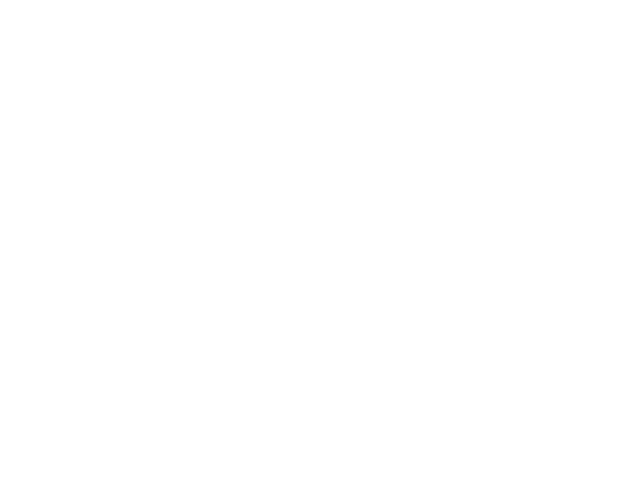

In [6]:
%matplotlib notebook


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ax = plt.axes(projection="3d")
# ax.plot(pred_x_se,pred_y_se,pred_z_se,color='red',label="pred_path")
ax.set_xlim(0,1200)
ax.set_ylim(-200,1000)
ax.set_zlim(-300,900)
ax.scatter(pred_x_se,pred_y_se,pred_z_se,color='red',label="pred_path")
ax.plot(np.array(total["POS_X"].tolist()),np.array(total["POS_Y"].tolist()),np.array(total["POS_Z"].tolist()),color='green',label="gt_path")
ax.legend(fontsize=20)

<IPython.core.display.Javascript object>


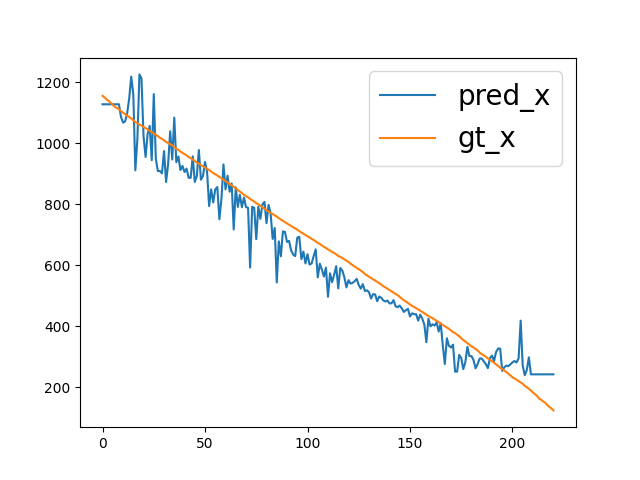

In [11]:
%matplotlib notebook

import matplotlib.pyplot as plt

for i in range(len(pred_x_se)):
    if pred_x_se[i]<200:
        pred_x_se[i] = pred_x_se[i-1] 
plt.plot(pred_x_se,label="pred_x")
plt.plot(total["POS_X"].tolist(),label="gt_x")
plt.legend(fontsize=20)

<IPython.core.display.Javascript object>


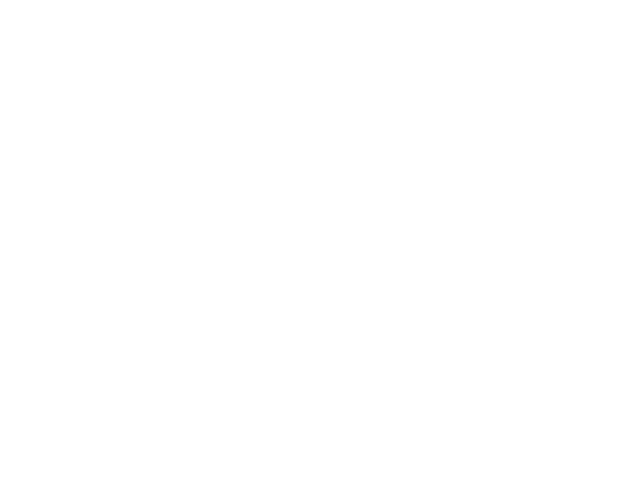

In [8]:
%matplotlib notebook

import matplotlib.pyplot as plt

for i in range(len(pred_y_se)):
    if pred_y_se[i]<-100 or pred_y_se[i]>200:
        pred_y_se[i] = pred_y_se[i-1] 

plt.ylim(-200,1000)
plt.plot(pred_y_se,label="pred_y")

plt.plot(total["POS_Y"].tolist(),label="gt_y")
plt.legend(fontsize=20)

<IPython.core.display.Javascript object>


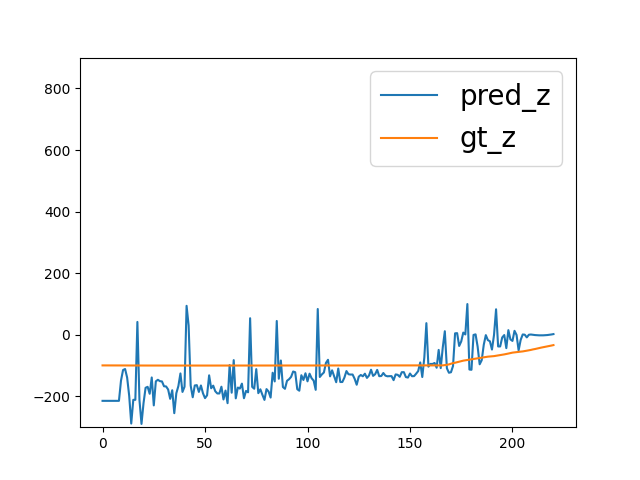

In [9]:
%matplotlib notebook

import matplotlib.pyplot as plt

for i in range(len(pred_z_se)):
    if pred_z_se[i]>100:
        pred_z_se[i] = pred_z_se[i-1] 
plt.ylim(-300,900)
plt.plot(pred_z_se,label="pred_z")
plt.plot(total["POS_Z"].tolist(),label="gt_z")
plt.legend(fontsize=20)

# 误差计算

In [13]:
dx_mean = np.mean(np.array(total["POS_X"].tolist()[:-10]) - pred_x_se[:-10])
dy_mean = np.mean(np.array(total["POS_Y"].tolist()[:-10]) - pred_y_se[:-10])
dz_mean = np.mean(np.array(total["POS_Z"].tolist()[:-10]) - pred_z_se[:-10])
print(dx_mean)
print(dy_mean)
print(dz_mean)




32.65056380111911
-35.457751562842844
27.15367369057782


In [21]:
import cv2

def haiya(image):
    image = cv2.imread(image)
    # gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 提取分割区域边缘
    canny_image = cv2.Canny(image,50,150)
    # 初步拟合分割区域边缘的跑道线
    cv2.imwrite("datasets/segment_canny_sample.png",canny_image)
    lines = cv2.HoughLinesP(canny_image, 3, 3 * np.pi/180, 40, minLineLength=10,maxLineGap=40)

    new_img = np.zeros_like(image)
    lines1 = lines[:,0,:]
    print(lines1)
    for line in lines1:
        cv2.line(new_img,(line[0],line[1]), (line[2],line[3]),(255,255,255))
    
    cv2.imwrite("datasets/segment_hough_sample.png",new_img)



image_name = "datasets/segment_feature_extraction_sample.png"
haiya(image_name)

[[100  57 122  35]
 [130  67 148  37]
 [ 94  65 117  37]]
